In [1]:
import logging
import warnings

import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.preprocessing.utils import *

# from .config import Config

In [2]:
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [34]:
indir = '/data/proj/chromium/10X232_4'

sample = indir.split('/')[-1]
bsize = 10000
genome_size = None
f_blacklist = None
min_frag = 500
outdir = '/data/proj/scATAC/chromograph/{}'.format(indir.split('/')[-1])

In [35]:
fb = indir + '/outs/singlecell.csv'
ff = indir + '/outs/fragments.tsv.gz'
fs = indir + '/outs/summary.json'

if not os.path.isdir(outdir):
    os.mkdir(outdir)

with open(fs, "r") as f:
    summary = json.load(f)
    
    for k,v in summary.items():
        summary[k] = str(v)

summary['bin_size'] = bsize

# bamfile = pysam.AlignmentFile(fbam, "rb", index_filename=fi)
barcodes = np.genfromtxt(fb, delimiter=',', skip_header=2,
                         dtype={'names':('barcode','total','duplicate','chimeric','unmapped','lowmapq','mitochondrial','passed_filters','cell_id','is__cell_barcode',
                                           'TSS_fragments','DNase_sensitive_region_fragments','enhancer_region_fragments','promoter_region_fragments','on_target_fragments',
                                           'blacklist_region_fragments','peak_region_fragments','peak_region_cutsites'),
                                 'formats':('U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8')})

## Transfer metadata to dict format
meta = {}
for key in barcodes.dtype.names:
    passed = np.logical_and(barcodes['is__cell_barcode'] == 1, barcodes['passed_filters'] > min_frag)
    meta[key] = barcodes[key][passed]
meta['sample'] = np.repeat(sample, len(meta['barcode']))
logging.info("Total of {} valid cells".format(len(meta['barcode'])))

# Get Chromosome sizes
if genome_size == None:
    chrom_size = get_chrom_sizes(summary['reference_assembly'])    
else:
    chrom_size = {}
    with open(genome_size) as f:
        for line in f:
            x = line.split()
            chrom_size[x[0]] = int(x[1])

19:27:00 INFO     Total of 3340 valid cells
19:27:00 INFO     Loaded chromatin sizes for GRCh38


In [36]:
## Read Fragments and generate size bins
logging.info("Read fragments into dict")
frag_dict = read_fragments(ff)
logging.info("Generate {} bins based on provided chromosome sizes".format(str(int(bsize/1000)) + ' kb'))
chrom_bins = generate_bins(chrom_size, bsize=bsize)

19:27:00 INFO     Read fragments into dict
19:27:27 INFO     barcodes: 97989   fragments: 7567983
19:27:31 INFO     Generate 10 kb bins based on provided chromosome sizes
19:27:31 INFO     Number of bins: 308839


In [37]:
meta['fragments'] = [frag_dict[k] for k in meta['barcode']]

## Count fragments inside bins based on cell barcodes

In [38]:
Count_dict = count_fragments(frag_dict, meta['barcode'], summary['bin_size'])

## Remove blacklisted regions

In [39]:
## Download Blacklist

# Load Blacklist
if f_blacklist == None:
    f_blacklist = get_blacklist(summary['reference_assembly'])    

blacklist = BedTool(f_blacklist)
bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
intervals = pybedtools.BedTool(bins)
cleaned = intervals.subtract(blacklist, A=True)

keep = [(row['chrom'], int(row['start']), int(row['end'])) for row in cleaned]
retain = [chrom_bins[x] for x in keep]
clean_bin = [bins[x] for x in retain]

print('Number of bins after cleaning: {}'.format(len(clean_bin)))

19:27:44 INFO     Retrieved blacklist for GRCh38


Number of bins after cleaning: 308818


## Construct loom file

In [40]:
## Create sparse matrix
col = []
row = []
v = []

cix = 0
for cell in meta['barcode']:
    
    for key in (Count_dict[cell]):
        col.append(cix)
        row.append(chrom_bins[key])
        v.append(Count_dict[cell][key])
    cix+=1

matrix = sparse.coo_matrix((v, (row,col)), shape=(len(chrom_bins.keys()), len(meta['barcode'])))

## Save a smaller section of the summary
keys = ['cellranger-atac_version', 'reference_assembly', 'reference_assembly_accession', 'reference_assembly_fasta_url', 'reference_organism', 'reference_version', 'bin_size']
small_summary = {k: summary[k] for k in keys}

## We retain only the bins that have no overlap with the ENCODE blacklist
cleaned_matrix = matrix.tocsr()[retain,:]
print('Identified {} positive bins in {} cells before filtering blacklist'.format(len(v), len(meta['barcode'])))
print('Identified {} positive bins in {} cells after filtering blacklist'.format(len(cleaned_matrix.nonzero()[0]), len(meta['barcode'])))

## Create row attributes
chrom = [x[0] for x in clean_bin]
start = [x[1] for x in clean_bin]
end = [x[2] for x in clean_bin]

row_attrs = {'chrom': chrom, 'start': start, 'end': end}

Identified 6230808 positive bins in 3340 cells before filtering blacklist
Identified 6230171 positive bins in 3340 cells after filtering blacklist


In [41]:
## Create loomfile
sampleid = indir.split('/')[-1] + '_' + str(int(bsize/1000)) + 'kb'
f = outdir + '/' + sampleid + '.loom'

loompy.create(filename=f, 
              layers=cleaned_matrix, 
              row_attrs=row_attrs, 
              col_attrs=meta,
              file_attrs=small_summary)

In [42]:
ds = loompy.connect(f)
ds.close()

(0, 1)

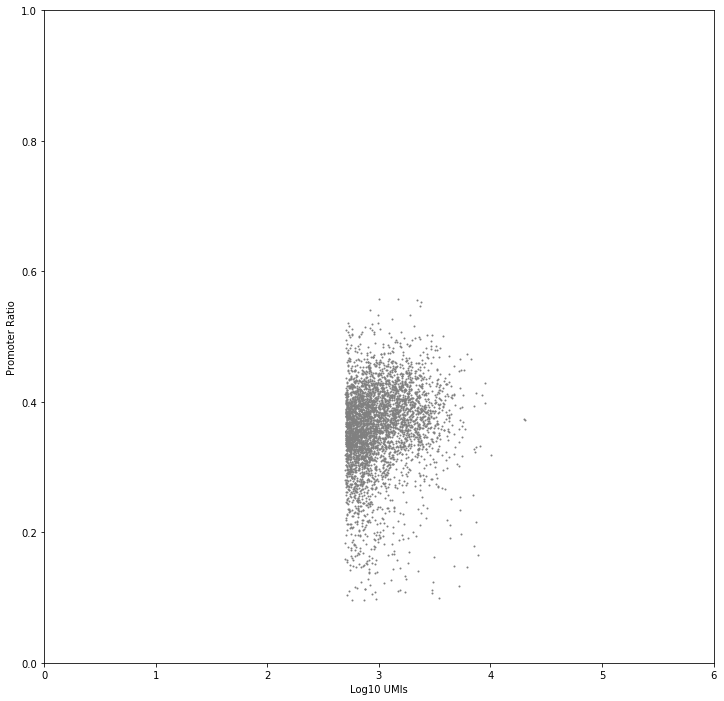

In [21]:
UMIs = np.log10(ds.ca['passed_filters'] + 1)
Prom_rat = (ds.ca['promoter_region_fragments'] + 1) / (ds.ca['passed_filters'] + 1)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(UMIs, Prom_rat, s=1, c='grey')
ax.set_xlabel('Log10 UMIs')
ax.set_ylabel('Promoter Ratio')
ax.set_xlim((0,6))
ax.set_ylim((0,1))

In [25]:
nnz = ds.map([np.count_nonzero], axis=1)[0]
nnz

array([2265.,  843.,  522., ...,  540.,  681.,  645.])

In [40]:
# class Chrombin:
#     def __init__(self) -> None:
#         """
#         Generate a binned loom file from scATAC-seq data
        
#         Args:
#             steps                    Which steps to include in the analysis

#         Remarks:
#             --- PUNCHCARD SUPPORT NEEDS TO INTEGRATED, FOR NOW PASS PARAMETER TO FIT FUNCTION ---
#             # All parameters are obtained from the config object, which comes from the default config
#             # and can be overridden by the config in the current punchcard
#         """
# #         self.config = config
#         logging.info("Chrombin initialised")
    
    
#     def fit(self, indir: str, bsize: int = 5000, outdir: str = None, genome_size: str = None, blacklist: str = None) -> None:
#         ''''
#         Create a .loom file from 10X Genomics cellranger output with reads binned
#         Args:
#             indir (str):	path to the cellranger output folder (the one that contains 'outs')
#             bsize (int):	size of the bins (defaults to 5000/5kb)
#             outdir (str):	output folder wher the new loom file should be saved (default to indir)
#             genome_size (str):	path to file containing chromosome sizes, usually derived from encode (i.e. 'hg19.chrom.sizes.tsv')
#             blacklist (str):	path to bedfile containing blacklisted region (i.e. 'blacklist_hg19.bed')
#         Returns:
#             path (str):		Full path to the created loom file.
#         Remarks:
#             The resulting file will be named ``{sampleID}.loom``, where the sampleID is the one given by cellranger.
#         '''
#         logging.info("Binning reads from {} into {} kb bins".format(indir.split('/')[-1], (bsize/1000)))
#         logging.info("Reading from dir {}".format(indir))
#         fb = indir + '/outs/singlecell.csv'
#         ff = indir + '/outs/fragments.tsv.gz'
#         fs = indir + '/outs/summary.json'

#         if not os.path.isdir(outdir):
#             os.mkdir(outdir)
   
#         logging.info("Reading metadata and summary from Cellranger output")
#         with open(fs, "r") as f:
#             summary = json.load(f)

#             for k,v in summary.items():
#                 summary[k] = str(v)
#         summary['bin_size'] = bsize
        
#         barcodes = np.genfromtxt(fb, delimiter=',', skip_header=2,
#                                  dtype={'names':('barcode','total','duplicate','chimeric','unmapped','lowmapq','mitochondrial','passed_filters','cell_id','is__cell_barcode',
#                                                    'TSS_fragments','DNase_sensitive_region_fragments','enhancer_region_fragments','promoter_region_fragments','on_target_fragments',
#                                                    'blacklist_region_fragments','peak_region_fragments','peak_region_cutsites'),
#                                          'formats':('U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8')})

#         ## Transfer metadata to dict format
#         meta = {}
#         for key in barcodes.dtype.names:
#             passed = np.logical_and(barcodes['is__cell_barcode'] == 1, barcodes['passed_filters'] > 1000)
#             meta[key] = barcodes[key][passed]
#         logging.info("Total of {} valid cells".format(len(meta['barcode'])))

#         # Get Chromosome sizes
#         if genome_size == None:
#             logging.info("Genome sizes not provided. Attempt download from ENCODE")            
#             chrom_size = download_chrom_sizes(summary['reference_assembly'])    
#         else:
#             chrom_size = {}
#             with open(genome_size) as f:
#                 for line in f:
#                     x = line.split()
#                     chrom_size[x[0]] = int(x[1])

#         ## Read Fragments and generate size bins
#         logging.info("Read fragments into dict")
#         frag_dict = read_fragments(ff)
#         logging.info("Generate {} bins based on provided chromosome sizes".format(str(int(bsize/1000)) + ' kb'))
#         chrom_bins = generate_bins(chrom_size, bsize)
#         logging.info("Saving Bed-files")
#         save_beds(frag_dict, outdir)

#         ## Count fragments inside bins
#         logging.info("Count fragments overlapping with bins")
#         Count_dict = count_fragments(frag_dict, meta['barcode'], bsize)

#         # Load Blacklist
#         if blacklist == None:
#             logging.info("Blacklist not provided. Attempt download from ENCODE")            
#             blacklist = download_blacklist(summary['reference_assembly'])    

#         logging.info("Remove bins that overlap with the ENCODE blacklist")
#         black_list = BedTool(blacklist)
#         bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
#         intervals = pybedtools.BedTool(bins)
#         cleaned = intervals.subtract(black_list, A=True)

#         keep = [(row['chrom'], int(row['start']), int(row['end'])) for row in cleaned]
#         retain = [chrom_bins[x] for x in keep]
#         clean_bin = [bins[x] for x in retain]

#         logging.info("Number of bins after cleaning: {}".format(len(clean_bin)))

#         ## Construct loom file

#         ## Create sparse matrix
        
#         logging.info("Generating Sparse matrix")
#         col = []
#         row = []
#         v = []

#         cix = 0
#         for cell in meta['barcode']:

#             for key in (Count_dict[cell]):
#                 col.append(cix)
#                 row.append(chrom_bins[key])
#                 v.append(Count_dict[cell][key])
#             cix+=1
#         matrix = sparse.coo_matrix((v, (row,col)), shape=(len(chrom_bins.keys()), len(meta['barcode'])))

#         ## We retain only the bins that have no overlap with the ENCODE blacklist
#         cleaned_matrix = matrix.tocsr()[retain,:]
#         logging.info("Identified {} positive bins in {} cells before filtering blacklist".format(len(v), len(meta['barcode'])))
#         logging.info("Identified {} positive bins in {} cells after filtering blacklist".format(len(cleaned_matrix.nonzero()[0]), len(meta['barcode'])))

#         ## Create row attributes
#         chrom = [x[0] for x in clean_bin]
#         start = [x[1] for x in clean_bin]
#         end = [x[2] for x in clean_bin]

#         row_attrs = {'chrom': chrom, 'start': start, 'end': end}

#         ## Create loomfile
#         logging.info("Constructing loomfile")
#         sampleid = indir.split('/')[-2] + '_' + str(int(bsize/1000)) + 'kb'
#         f = outdir + '/' + sampleid + '.loom'

#         loompy.create(filename=f, 
#                       layers=cleaned_matrix, 
#                       row_attrs=row_attrs, 
#                       col_attrs=meta,
#                       file_attrs=summary)
        
#         logging.info("Loom file saved as {}".format(f))
    
# def download_chrom_sizes(ref: str):
#     '''
#     '''

#     url = 'https://www.encodeproject.org/files/male.{}.chrom.sizes/@@download/male.{}.chrom.sizes.tsv'.format(ref, ref)
#     logging.info("url: {}".format(url))

#     tmp = urllib.request.urlopen(url)
#     datatowrite = tmp.read()

#     if not os.path.isdir('./tmp'):
#         os.mkdir('tmp')

#     with open('tmp/male.{}.chrom.sizes'.format(ref), 'wb') as f:
#         f.write(datatowrite)

#     chrom_size = {}
#     with open('tmp/male.{}.chrom.sizes'.format(ref), 'rb') as f:
#         for line in f:
#             x = line.split()
#             chrom_size[x[0].decode()] = int(x[1].decode())
#     return chrom_size;

# def download_blacklist(ref: str):
#     '''
#     '''

#     if ref == 'hg19':
#         url = 'https://www.encodeproject.org/files/ENCFF547MET/@@download/ENCFF547MET.bed.gz'.format(ref, ref)
#         logging.info("url: {}".format(url))
#     elif ref == 'mm10':
#         url = 'https://www.encodeproject.org/files/ENCFF001TDO/@@download/ENCFF001TDO.bed.gz'
#         logging.info("url: {}".format(url))        
#     else:
#         logging.info("Genome not recognised")
#         return
    
#     tmp = urllib.request.urlopen(url)
#     datatowrite = tmp.read()

#     if not os.path.isdir('./tmp'):
#         os.mkdir('tmp')

#     file = 'tmp/blacklist_{}.bed'.format(ref)
        
#     with open(file, 'wb') as f:
#         f.write(datatowrite)

#     return file;

# def read_fragments(file):
#     '''
#     '''
    
#     frag_dict = collections.OrderedDict()
#     new = 0
#     add = 0
#     with gzip.open(file, 'rb') as f:
#         for read in f:
#             r = read.split()
#             b = r[3].decode()

#             if b not in frag_dict:
#                 frag_dict[b] = [[r[0].decode(), int(r[1].decode()), int(r[2].decode())]]
#                 new += 1
#             else:
#                 frag_dict[b].append([r[0].decode(), int(r[1].decode()), int(r[2].decode())])
#                 add += 1
    
#         logging.info("barcodes: {}   fragments: {}".format(new, (new+add)))
#         return frag_dict;
    
# def generate_bins(chrom_size, bsize):
#     '''
#     '''
    
#     chrom_bins = collections.OrderedDict();
#     i = 0
#     for x in chrom_size.keys():
#         for start in range(1, chrom_size[x], bsize):
#             end = min(start + bsize - 1, chrom_size[x]);
#             bin = (x , start, end);
#             chrom_bins[bin] = i;
#             i += 1
#     logging.info("Number of bins: {}".format(len(chrom_bins.keys())))
#     return chrom_bins;

# def count_fragments(frag_dict, barcodes, bsize):
#     '''
#     '''
    
#     Count_dict = collections.OrderedDict()

#     for bar in barcodes:    
#         if bar in frag_dict:
#             frags = frag_dict[bar]
#             counts = {}
#             for _frag in frags:

#                 # If a fragment spans two bins we count it twice
#                 for x in set([int(_frag[1]/bsize)*bsize+1, int(_frag[2]/bsize)*bsize+1]):
#                     k = (_frag[0], x, x + bsize - 1)
#                     if k not in counts.keys():
#                         counts[k] = 1
#                     else:
#                         counts[k] += 1
#             Count_dict[bar] = counts
#         else:
#             continue
    
#     return Count_dict;

# def save_beds(frag_dict, barcodes, outdir):
#     fdir = outdir + '/fragments/'

#     if not os.path.isdir(fdir):
#         os.mkdir(fdir)
        
#     if barcodes == None:
#         barcodes = frag_dict.keys()
    
#     for bar in barcodes:
#         frags = [(k[0], str(k[1]), str(k[2])) for k in frag_dict[bar]]
#         bed = BedTool(frags)
#         bed.saveas(fdir + bar + '.bed.gz')
    
#     logging.info("Saved bedfiles of cells to {}".format(fdir))

In [13]:
# chrombin = Chrombin()
# chrombin.fit(indir = '/data/proj/scATAC/10X_test/atac_v1_E18_brain_fresh_5k_S1_cell_ranger', 
#              bsize = 10000, outdir = '/data/proj/scATAC/chromograph/atac_v1_E18_brain_fresh_5k_test2')

INFO:root:Chrombin initialised
INFO:root:Binning reads from atac_v1_E18_brain_fresh_5k_S1_cell_ranger into 10.0 kb bins
INFO:root:Reading from dir /data/proj/scATAC/10X_test/atac_v1_E18_brain_fresh_5k_S1_cell_ranger
INFO:root:Reading metadata and summary from Cellranger output
INFO:root:Total of 4273 valid cells
INFO:root:Genome sizes not provided. Attempt download from ENCODE
INFO:root:url: https://www.encodeproject.org/files/male.mm10.chrom.sizes/@@download/male.mm10.chrom.sizes.tsv
INFO:root:Read fragments into dict
INFO:root:barcodes: 329571   fragments: 87541137
INFO:root:Generate 10 kb bins based on provided chromosome sizes
INFO:root:Number of bins: 272566
INFO:root:Count fragments overlapping with bins
INFO:root:Blacklist not provided. Attempt download from ENCODE
INFO:root:url: https://www.encodeproject.org/files/ENCFF001TDO/@@download/ENCFF001TDO.bed.gz
INFO:root:Remove bins that overlap with the ENCODE blacklist
INFO:root:Number of bins after cleaning: 271145
INFO:root:Gener